<a href="https://colab.research.google.com/github/mobarakol/tutorial_notebooks/blob/main/bbox_depth_visualization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#2D bbox visualization

Download image and bbox annotation xml.

In [ ]:
!git clone https://github.com/mobarakol/MICCAI-2017-Robotic-Instrument-Segmentation.git

Cloning into 'MICCAI-2017-Robotic-Instrument-Segmentation'...
remote: Enumerating objects: 75, done.
remote: Counting objects: 100% (75/75), done.
remote: Compressing objects: 100% (71/71), done.
remote: Total 75 (delta 21), reused 8 (delta 0), pack-reused 0
Unpacking objects: 100% (75/75), done.


visualization

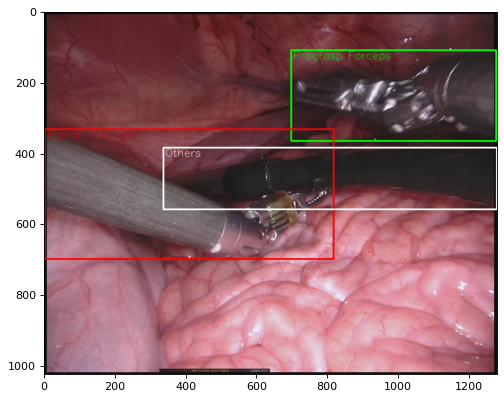

In [ ]:

import os
import sys
import cv2
from glob import glob
from PIL import Image
%matplotlib inline
from matplotlib import pyplot as plt
plt.figure(figsize=(8, 6), dpi=80)

if sys.version_info[0] == 2:
    import xml.etree.cElementTree as ET
else:
    import xml.etree.ElementTree as ET

font = cv2.FONT_HERSHEY_SIMPLEX
INSTRUMENT_CLASSES = ( '', 'Bipolar Forceps', 'Prograsp Forceps', 'Large Needle Driver', 'Vessel Sealer',
    'Grasping Retractor', 'Monopolar Curved Scissors', 'Others')

#bbox color for each class
color_mode = [(0,0,255),(0,255,0),(255,0,0),(0,255,255),(255,0,255),(255,255,0),(255,255,255)]

for img_name in glob('MICCAI-2017-Robotic-Instrument-Segmentation/instrument_dataset_1/images/frame000.jpg'):
    _img_orig = Image.open(img_name).convert('RGB')
    img  = cv2.imread(img_name)
    _xml_dir = os.path.dirname(os.path.dirname(img_name)) + '/xml/' + os.path.basename(img_name[:-4]) + '.xml'
    _xml = ET.parse(_xml_dir).getroot()
    class_to_ind = dict(zip(INSTRUMENT_CLASSES, range(len(INSTRUMENT_CLASSES))))
    
    for obj in _xml.iter('objects'):
        name = obj.find('name').text.strip()
        bbox = obj.find('bndbox')
        bbox_col = INSTRUMENT_CLASSES.index(str(name)) - 1;
        pts = ['xmin', 'ymin', 'xmax', 'ymax']
        bndbox = []
        label_idx = class_to_ind[name]
        for i, pt in enumerate(pts):         
            cur_pt = int(bbox.find(pt).text)
            bndbox.append(cur_pt)
            
        top_corner, down_corner = (int(bndbox[0]), int(bndbox[1])), (int(bndbox[2]), int(bndbox[3]))
        cv2.rectangle(img, top_corner, down_corner, color_mode[bbox_col], thickness=4)
        cv2.putText(img,str(name),(top_corner[0]+5, top_corner[1]+25), font, 1,color_mode[bbox_col],1,cv2.LINE_AA)       
        plt.imshow(img[:,:,::-1])
        plt.imsave(os.path.basename(img_name), img[:,:,::-1])

#Depth
Installation

In [1]:
!pip -q install transformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 42.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.6/7.6 MB 30.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 190.3/190.3 KB 11.0 MB/s eta 0:00:00


Download sample data

In [2]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

ids = ['1Q45JutY3Fu4wqf4z_Xarz6CTJnyofnSx']
zip_files = ['instrument17_valid.zip']
for id, zip_file in zip(ids, zip_files):
    downloaded = drive.CreateFile({'id':id}) 
    downloaded.GetContentFile(zip_file)
    if zip_file[-3:] == 'zip':
        !unzip -q $zip_file

Sample Datalaoder

In [4]:
from glob import glob
from PIL import Image
import numpy as np
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import tifffile
import cv2
import gdown
import os

class TestDataset(Dataset):
    def __init__(self, path_depth=None, transform=None):
        self.path_depth = path_depth
        self.transform = transform

    def __len__(self):
      return len(self.path_depth)   

    def __getitem__(self, i):
        img = Image.open(self.path_depth[i]).convert('RGB')
        if self.transform:
            img = self.transform(img)
        return img


transform_test = transforms.Compose([
    transforms.Resize((256, 320)), 
    transforms.ToTensor(),    
])

data_root_dir = 'instrument17_valid/**/images/'
img_dir = glob(data_root_dir + '*.jpg')
dataset_test = TestDataset(path_depth=img_dir, transform=transform_test)
print('test sample:', len(dataset_test))

test sample: 450


/usr/local/lib/python3.8/dist-packages/transformers/models/dpt/feature_extraction_dpt.py:28: FutureWarning: The class DPTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DPTImageProcessor instead.
  warnings.warn(


Some weights of DPTForDepthEstimation were not initialized from the model checkpoint at Intel/dpt-large and are newly initialized: ['neck.fusion_stage.layers.0.residual_layer1.convolution1.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.weight', 'neck.fusion_stage.layers.0.residual_layer1.convolution2.bias', 'neck.fusion_stage.layers.0.residual_layer1.convolution1.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


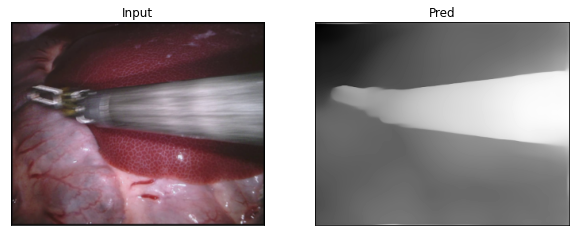

In [5]:
from transformers import DPTFeatureExtractor, DPTForDepthEstimation
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
feature_extractor = DPTFeatureExtractor.from_pretrained("Intel/dpt-large")
depth_estimation = DPTForDepthEstimation.from_pretrained("Intel/dpt-large").to(device)

image_raw = transforms.ToPILImage()(dataset_test[0])#[None]
image = image_raw.resize((800, int(800 * image_raw.size[1] / image_raw.size[0])), Image.LANCZOS)# Image.Resampling.LANCZOS)
encoding = feature_extractor(image, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = depth_estimation(**encoding)
    # print(outputs.__dict__.keys())#['loss', 'predicted_depth', 'hidden_states', 'attentions']
    predicted_depth = outputs.predicted_depth
    prediction = torch.nn.functional.interpolate(
        predicted_depth.unsqueeze(1),
        size=image_raw.size[::-1],
        mode="bicubic",
        align_corners=False,
    ).squeeze()
output = prediction.cpu().numpy() 

num_img = 2
fig, ax = plt.subplots(1, num_img, figsize=(5*num_img,5), subplot_kw=dict(xticks=[],yticks=[]))
ax[0].imshow(dataset_test[0].permute(1,2,0))
ax[0].set_title('Input')
ax[1].imshow(output, cmap='gray')
ax[1].set_title('Pred');

#Sample 2D detector
Installation

In [8]:
!pip install -q transformers wget

  Preparing metadata (setup.py) ... done


In [6]:
!git clone https://github.com/huggingface/transformers.git
%cd transformers/examples/research_projects/visual_bert

Cloning into 'transformers'...
remote: Enumerating objects: 132252, done.
remote: Counting objects: 100% (109/109), done.
remote: Compressing objects: 100% (90/90), done.
remote: Total 132252 (delta 40), reused 37 (delta 10), pack-reused 132143
Receiving objects: 100% (132252/132252), 126.56 MiB | 23.93 MiB/s, done.
Resolving deltas: 100% (100062/100062), done.
/content/transformers/examples/research_projects/visual_bert


loading configuration file cache
loading weights file https://cdn.huggingface.co/unc-nlp/frcnn-vg-finetuned/pytorch_model.bin from cache at /root/.cache/torch/transformers/57f6df6abe353be2773f2700159c65615babf39ab5b48114d2b49267672ae10f.77b59256a4cf8343ae0f923246a81489fc8d82f98d082edc2d2037c977c0d9d0
All model checkpoint weights were used when initializing GeneralizedRCNN.

All the weights of GeneralizedRCNN were initialized from the model checkpoint at unc-nlp/frcnn-vg-finetuned.
If your task is similar to the task the model of the checkpoint was trained on, you can already use GeneralizedRCNN for predictions without further training.
boxes: torch.Size([1, 36, 4]) obj_ids: torch.Size([1, 36]) attr_ids: torch.Size([1, 36])


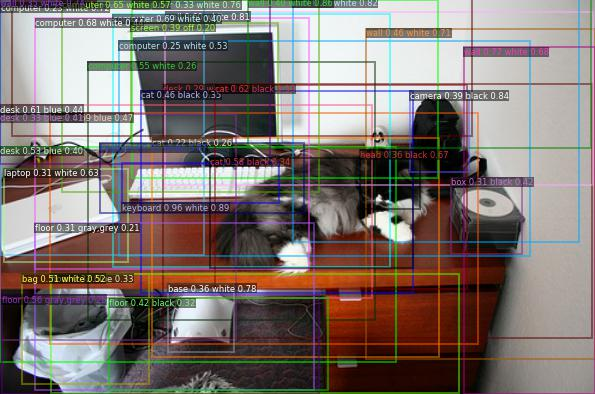

In [25]:
import matplotlib.pyplot as plt
from PIL import Image
import requests
from utils import Config
from modeling_frcnn import GeneralizedRCNN
from visualizing_image import SingleImageViz
import io
import PIL.Image

frcnn_cfg = Config.from_pretrained("unc-nlp/frcnn-vg-finetuned")
frcnn = GeneralizedRCNN.from_pretrained("unc-nlp/frcnn-vg-finetuned", config=frcnn_cfg);

URL = "https://miro.medium.com/max/992/1*7jn1sgbhz3fNJweDFTHrrw.png"
img_raw = Image.open(requests.get(URL, stream=True).raw)
raw_sizes = torch.tensor(np.array(img_raw).shape[:2])
sizes = torch.tensor([800, 1206])
scales_yx = torch.true_divide(raw_sizes, sizes)

pil_image = img_raw.resize((1206, 800), Image.BILINEAR) # PIL image wxh where other lib hxw
normalizer = lambda x: (x - [102.9801, 115.9465, 122.7717]) / [1.0, 1.0, 1.0] 
images_mine = torch.tensor(normalizer(np.array(pil_image))).double().permute(2, 0,1)[None]

output_dict = frcnn(
    images_mine.float(),
    torch.tensor([[800, 1206]]),
    scales_yx=torch.tensor([[0.4112, 0.4113]]),
    padding="max_detections",
    max_detections=frcnn_cfg.max_detections,
    return_tensors="pt",
)

print( 'boxes:', output_dict.get("boxes").shape,
      'obj_ids:', output_dict.get("obj_ids").shape, 'attr_ids:', output_dict.get("attr_ids").shape,)
# for visualizing output

def showarray(a, fmt="jpeg"):
    from IPython.display import Image, display
    a = np.uint8(np.clip(a, 0, 255))
    f = io.BytesIO()
    PIL.Image.fromarray(a).save(f, fmt)
    display(Image(data=f.getvalue()))

# image viz
OBJ_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/objects_vocab.txt"
ATTR_URL = "https://raw.githubusercontent.com/airsplay/py-bottom-up-attention/master/demo/data/genome/1600-400-20/attributes_vocab.txt"
objids = utils.get_data(OBJ_URL)
attrids = utils.get_data(ATTR_URL)
frcnn_visualizer = SingleImageViz(URL, id2obj=objids, id2attr=attrids)

# add boxes and labels to the image

frcnn_visualizer.draw_boxes(
    output_dict.get("boxes"),
    output_dict.pop("obj_ids"),
    output_dict.pop("obj_probs"),
    output_dict.pop("attr_ids"),
    output_dict.pop("attr_probs"),
)
showarray(frcnn_visualizer._get_buffer())
